# Digit recognition using Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

## Load the data

Read in the training data:

In [2]:
data = pd.read_csv('./data/train.csv')

In [3]:
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [4]:
len(data)

42000

## Format the data

In its current form, this data is just a 42000-sample dataframe with 784 pixel columns, i.e. each positional pixel has its own column. Therefore, to get the samples back into their visually coherent form, we need to reshape the data to a set of 28 by 28 arrays (and add an extra 'channel' dimension at the end, to conform with tensorflow's input requirements):

In [5]:
X_data = data.drop('label', axis=1).values
X_data = np.reshape(X_data, (len(data), 28, 28))
X_data = np.expand_dims(X_data, axis=-1)
print(np.shape(X_data))

(42000, 28, 28, 1)


Let's also extract our labels for each sample:

In [6]:
y_data = data['label'].values
print(np.shape(y_data))

(42000,)


## Inspect the data

To make sure this worked as expected, let's plot a series of digits to make sure they're legible:

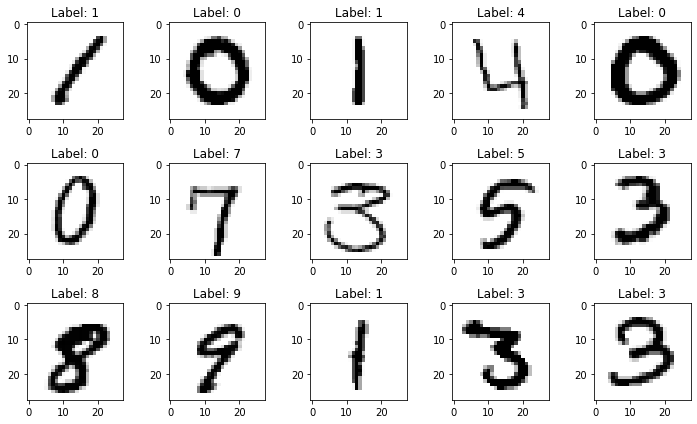

In [7]:
plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.squeeze(X_data[i]), cmap=plt.cm.binary)
    plt.title(f'Label: {y_data[i]}')
plt.tight_layout()
plt.show()

Also, it might be interesting to see what the 'average image' is for each digit, to get an idea of the variability between each individual sample.

In [8]:
average = data.groupby('label').mean()

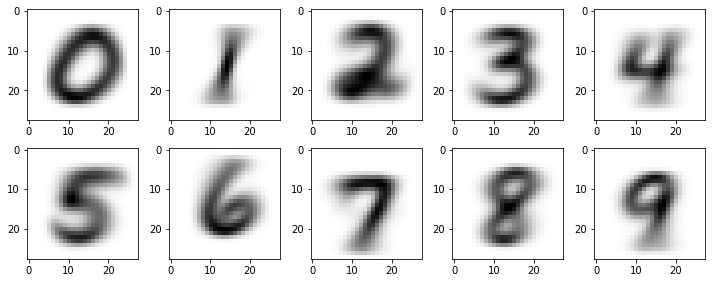

In [9]:
X_data_avg = np.reshape(average.values, (10, 28, 28))
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.squeeze(X_data_avg[i]), cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

## Build the model

Looks good. Now let's construct a Convolutional Neural Network to learn these digits. We'll add in three convolutional layers, split up with two maximum pooling layers. The output from this segment of the model is a 3 by 3 array. This then gets flattened and run through a fully connected (dense) layer.

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's what the model looks like:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                7

## Fit the model

Split the data into training and testing sets:

In [12]:
X_train, X_test, y_train, y_test = (
    train_test_split(X_data, y_data, test_size=0.2, shuffle=True)
)

Now compile and fit the model:

In [13]:
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 29s 859us/sample - loss: 0.2289 - accuracy: 0.9414 - val_loss: 0.1197 - val_accuracy: 0.9614
Epoch 2/10
33600/33600 [==============================] - 25s 750us/sample - loss: 0.0630 - accuracy: 0.9807 - val_loss: 0.0655 - val_accuracy: 0.9811
Epoch 3/10
33600/33600 [==============================] - 34s 1ms/sample - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0758 - val_accuracy: 0.9794
Epoch 4/10
33600/33600 [==============================] - 31s 933us/sample - loss: 0.0420 - accuracy: 0.9879 - val_loss: 0.0813 - val_accuracy: 0.9765
Epoch 5/10
33600/33600 [==============================] - 29s 871us/sample - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0626 - val_accuracy: 0.9827
Epoch 6/10
33600/33600 [==============================] - 26s 768us/sample - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.0682 - val_accuracy: 0.9817
Epoch 7/10
33600/33600 [=======================

## Assess model accuracy

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

8400/8400 - 1s - loss: 0.0922 - accuracy: 0.9825


This results in a model accuracy of over 98% on the test set. We can see how the training and validation (test) accuracy evolved over training epochs below:

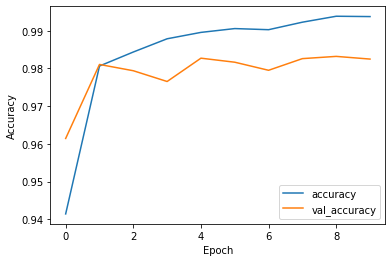

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Not bad, but can we do better? One noticeable feature of the above results is that the training accuracy of model is quite a bit higher than the validation accuracy. This suggests that some overfitting is occurring. Therefore, we may be able to produce a more general model by reducing this overfit effect. Let's use PCA to reduce the dimensionality of our dataset.

## Dimensionality reduction with PCA

First of all, we'll need to scale this data before doing PCA on it.

In [17]:
X_data_scaled = data.drop('label', axis=1).values
scaler = MinMaxScaler().fit(X_data_scaled)
X_data_scaled = scaler.transform(X_data_scaled)

Now let's run a PCA and explore the cumulative variance captured by the model:

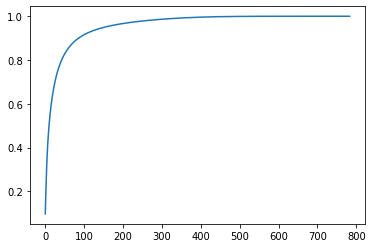

In [18]:
pca = PCA().fit(X_data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Despite our original vector space being 784-dimensional, PCA indicates that over 90% of the variance in the images is accounted for by only the first 100 eigenvectors. Therefore, we can substantially reduce the dimensionality of our dataset if we project it onto this new space, thereby also generalising the data to a degree. 

In [19]:
np.cumsum(pca.explained_variance_ratio_)[70]

0.8764397927945604

Let's take the first 70 eigenvectors (which explain about 88% of the variance), project the original dataset onto this space, and then transform it back to our original dimensions. This will result in a set of information-lean digits.

In [20]:
pca = PCA(n_components=70).fit(X_data_scaled)
X_data_proj = pca.transform(X_data_scaled)
X_data_proj = pca.inverse_transform(X_data_proj)
X_data_proj = np.reshape(X_data_proj, (len(data), 28, 28))
X_data_proj = np.expand_dims(X_data_proj, axis=-1)
print(np.shape(X_data_proj))

(42000, 28, 28, 1)


Here's what the manipulated data looks like:

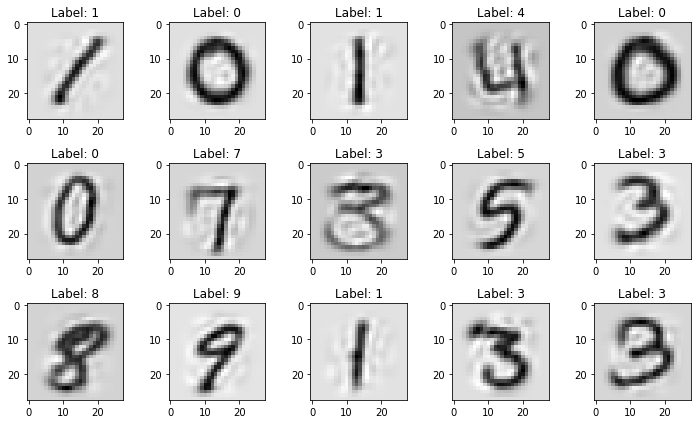

In [21]:
plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(np.squeeze(X_data_proj[i]), cmap=plt.cm.binary)
    plt.title(f'Label: {y_data[i]}')
plt.tight_layout()
plt.show()

Pretty ugly, but hopefully conducive to some substantial improvements in the model's accuracy. Let's see how it goes.

In [22]:
X_train_proj, X_test_proj, y_train_proj, y_test_proj = (
    train_test_split(X_data_proj, y_data, test_size=0.2, shuffle=True)
)

In [23]:
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    X_train_proj, y_train_proj, epochs=10, validation_data=(X_test_proj, y_test_proj)
)

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 28s 827us/sample - loss: 0.1519 - accuracy: 0.9511 - val_loss: 0.0445 - val_accuracy: 0.9869
Epoch 2/10
33600/33600 [==============================] - 32s 941us/sample - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.0344 - val_accuracy: 0.9889
Epoch 3/10
33600/33600 [==============================] - 27s 807us/sample - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0383 - val_accuracy: 0.9870
Epoch 4/10
33600/33600 [==============================] - 25s 741us/sample - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0306 - val_accuracy: 0.9905
Epoch 5/10
33600/33600 [==============================] - 26s 779us/sample - loss: 0.0111 - accuracy: 0.9966 - val_loss: 0.0328 - val_accuracy: 0.9892
Epoch 6/10
33600/33600 [==============================] - 36s 1ms/sample - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0626 - val_accuracy: 0.9832
Epoch 7/10
33600/33600 [=======================

In [25]:
test_loss, test_acc = model.evaluate(X_test_proj, y_test_proj, verbose=2)

8400/8400 - 1s - loss: 0.0456 - accuracy: 0.9886


Compared to the previous run, we can see substantial improvements in both the training and validation accuracy. After 10 epochs, the training accuracy is running at almost 99.9%, whilst the validation accuracy is almost 98.9%. This is an improvement overall, and we've clearly reduced the overfit exhibitted in the original model run.

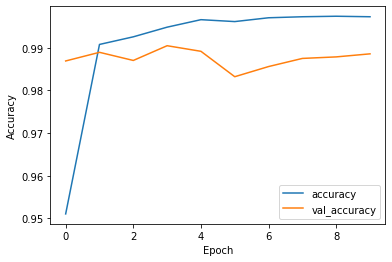

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Also, it is interesting to note that the model appears to have achieved near-optimal accuracy after only 1 epoch. This is in contrast to the previous run which still suggested some room for improvement after 10 epochs. So greater accuracy and efficiency!

## Produce submission results

Before producing the submission results, let's add a softmax layer to the model so that it returns label probabilities rather than logits.

In [27]:
prob_model = models.Sequential([model, layers.Softmax()])

To get a single label prediction from a set of probabilities, we'll simply go with the highest probability. Here are the first ten label predictions from the test set:

In [28]:
np.argmax(prob_model.predict(X_test_proj), axis=1)[:10]

array([7, 3, 1, 2, 4, 1, 7, 1, 2, 1])

Now let's read in the prediction data used for submission to Kaggle, and run our model on it.

In [29]:
pred_data = pd.read_csv('./data/test.csv')

In [30]:
X_pred_data = scaler.transform(pred_data.values)
X_pred_data = pca.transform(X_pred_data)
X_pred_data = pca.inverse_transform(X_pred_data)
X_pred_data = np.reshape(X_pred_data, (len(pred_data), 28, 28))
X_pred_data = np.expand_dims(X_pred_data, axis=-1)
print(np.shape(X_pred_data))

(28000, 28, 28, 1)


In [31]:
predictions = np.argmax(prob_model.predict(X_pred_data), axis=1)

Now, just for a sanity check, let's visualise some of the samples, along with their predicted label:

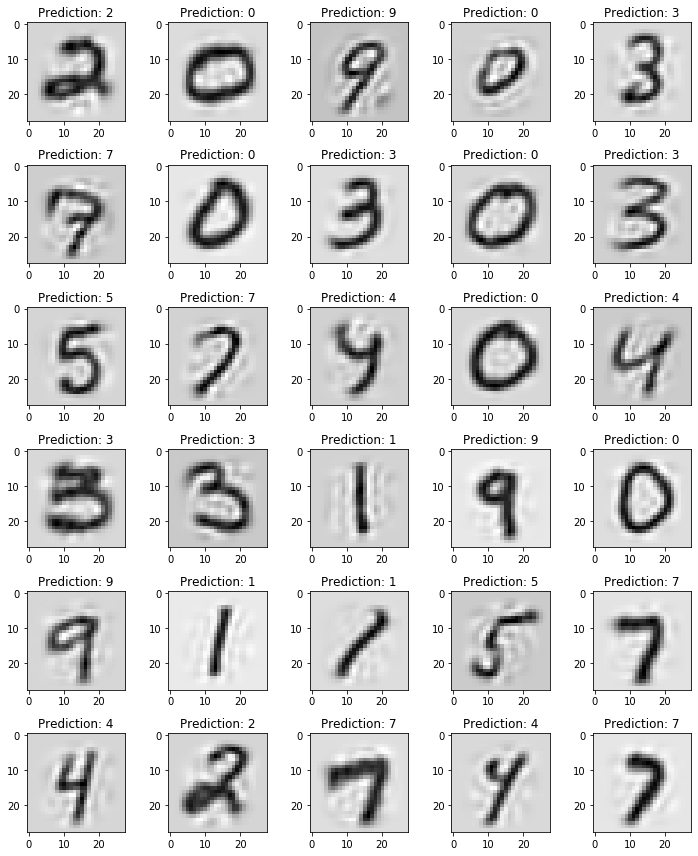

In [32]:
plt.figure(figsize=(10,12))
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(np.squeeze(X_pred_data[i]), cmap=plt.cm.binary)
    plt.title(f'Prediction: {predictions[i]}')
plt.tight_layout()
plt.show()

These all look correct. Now write the results to a csv file for submission:

In [33]:
result = pd.DataFrame(
    data=np.array([np.array(pred_data.index+1), predictions]).T,
    columns=['ImageId', 'Label']
)

In [34]:
result.head()

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3

In [35]:
result.to_csv('./data/submission.csv', index=False)

This resulted in an accuracy 99.128% on Kaggle, putting it in the top 35% of submissions.